In [1]:
import numpy as np
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

import qiskit
from qiskit import Aer, execute, QuantumCircuit, QuantumRegister, IBMQ
from qiskit.circuit import ClassicalRegister
from qiskit.compiler import transpile

In [2]:
IBMQ.load_account()
provider = IBMQ.providers()[-1]

/Users/bpnachman/opt/anaconda3/envs/Qiskit/lib/python3.8/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


In [3]:
def mybin(input,q,r=1):
    #Utility for converting to binary representation. 
    #r stands for "reverse" because Qiskit's convention is often backwards of mine.
    if (r==0):
        return bin(input).split('b')[1].zfill(q) 
    else:
        return bin(input).split('b')[1].zfill(q)[::-1]

In [4]:
backend = provider.get_backend('ibmq_manhattan')
#coupling_map = backend.configuration().coupling_map

circs = []

for i in range(2**5):
    
    qr = QuantumRegister(26, 'qr')
    cr = ClassicalRegister(26, 'cr')
    circ = QuantumCircuit(qr, cr)

    #Logical qubits
    #circ.h(15)
    #circ.h(16)
    #circ.h(17)
    #circ.h(18)
    #circ.h(19)
    
    binnumber_initial = mybin(i,5)
    for j in range(5):
        if (binnumber_initial[j]=='1'):
            circ.x(qr[j+15])
            pass
        pass
    
    circ.cx(15,14)
    circ.cx(15,24)

    circ.cx(19,20)
    circ.cx(19,25)

    circ.cx(17,11)
    
    circ.name='cal_'+binnumber_initial[::-1] #Their convention is backwards of mine.
    circ.name=circ.name
    for i in range(6):
        circ.measure(15+i,15+i)
    circ.measure(14,14)
    circ.measure(24,24)
    circ.measure(20,20)
    circ.measure(25,25)
    circ.measure(11,11)
    mapped_circuit = transpile(circ, backend=backend, optimization_level=0)
    circs+=[mapped_circuit]
    
#### Now for the circuit without the encoding

for i in range(2**5):
    
    qr = QuantumRegister(26, 'qr')
    cr = ClassicalRegister(26, 'cr')
    circ = QuantumCircuit(qr, cr)

    #Logical qubits
    #circ.h(15)
    #circ.h(16)
    #circ.h(17)
    #circ.h(18)
    #circ.h(19)
    
    binnumber_initial = mybin(i,5)
    for j in range(5):
        if (binnumber_initial[j]=='1'):
            circ.x(qr[j+15])
            pass
        pass
    
    circ.name='cal2_'+binnumber_initial[::-1] #Their convention is backwards of mine.
    circ.name=circ.name
    for i in range(6):
        circ.measure(15+i,15+i)
    circ.measure(14,14)
    circ.measure(24,24)
    circ.measure(20,20)
    circ.measure(25,25)
    circ.measure(11,11)
    mapped_circuit = transpile(circ, backend=backend, optimization_level=0)
    circs+=[mapped_circuit]

In [5]:
from qiskit.providers.ibmq.managed import IBMQJobManager

In [6]:
#job_manager = IBMQJobManager()
#job_set = job_manager.run(circs, backend=backend, name='myruns', shots=8192)
#print(job_set.job_set_id())

In [7]:
#results = job_set.results()
#for i in range(2*2**5):
#    np.save("results/1036b206a7b64e1fb6424259954ddecb-1626024271572693_"+str(i)+".npy",results.get_counts(i))

In [8]:
myres = {}
for i in range(2**5):
    myres[i] = np.load("results/1036b206a7b64e1fb6424259954ddecb-1626024271572693_"+str(i)+".npy",allow_pickle=True).item()
    
myres_nom = {}
for i in range(2**5,2*2**5):
    myres_nom[i-2**5] = np.load("results/1036b206a7b64e1fb6424259954ddecb-1626024271572693_"+str(i)+".npy",allow_pickle=True).item()

In [9]:
myresponse = np.zeros([2**5,2**5])
myresponse2 = np.zeros([2**5,2**5])

ovals = {}
ovals[17,0]=[]
ovals[17,1]=[]
ovals[17,2]=[]

ovals[15,0]=[]
ovals[15,1]=[]
ovals[15,2]=[]

ovals[19,0]=[]
ovals[19,1]=[]
ovals[19,2]=[]

for ii in range(2**5):
    vals = myres[ii]
    vals2 = myres[ii].copy()
    
    vals_nom = myres_nom[ii]
    vals2_nom = myres_nom[ii].copy()
    
    corr = 0
    notcorr = 0
    
    corr2 = 0
    notcorr2 = 0
    
    rightanswer = '0'
    binnumber_initial = mybin(ii,5)
    if (binnumber_initial[0]=='1'):
        rightanswer = '1'
    
    for j in vals:
        if (j[::-1][15]==rightanswer):
            corr+=vals[j]
        else:
            notcorr+=vals[j]
    
    corrB = 0
    notcorrB = 0
    
    for j in vals_nom:
        if (j[::-1][15]==rightanswer):
            corrB+=vals_nom[j]
        else:
            notcorrB+=vals_nom[j]
    
    ierr = 0
    isnoterror = 0
    for j in vals:            
        if (j[::-1][15]=='1' and j[::-1][14]=='1' and j[::-1][24]=='1'):
            isnoterror += vals[j]
            
            if (j[::-1][15]==rightanswer):
                corr2+=vals[j]
            else:
                notcorr2+=vals[j]
            
            pass #no error
        if (j[::-1][15]=='0' and j[::-1][14]=='0' and j[::-1][24]=='0'):
            isnoterror += vals[j]
            
            if (j[::-1][15]==rightanswer):
                corr2+=vals[j]
            else:
                notcorr2+=vals[j]
            
            pass #no error
        if (j[::-1][15]=='0' and j[::-1][14]=='0' and j[::-1][24]=='1'):
            isnoterror += vals[j]
            
            if (j[::-1][15]==rightanswer):
                corr2+=vals[j]
            else:
                notcorr2+=vals[j]
            
            pass #no error
        if (j[::-1][15]=='0' and j[::-1][14]=='1' and j[::-1][24]=='0'):
            isnoterror += vals[j]
            
            if (j[::-1][15]==rightanswer):
                corr2+=vals[j]
            else:
                notcorr2+=vals[j]
            
            pass #no error        
        if (j[::-1][15]=='1' and j[::-1][14]=='0' and j[::-1][24]=='1'):
            isnoterror += vals[j]
    
            if (j[::-1][15]==rightanswer):
                corr2+=vals[j]
            else:
                notcorr2+=vals[j]
            
            pass #no error
        if (j[::-1][15]=='1' and j[::-1][14]=='1' and j[::-1][24]=='0'):
            isnoterror += vals[j]
            
            if (j[::-1][15]==rightanswer):
                corr2+=vals[j]
            else:
                notcorr2+=vals[j]
            
            pass #no error      
        if (j[::-1][15]=='1' and j[::-1][14]=='0' and j[::-1][24]=='0'):
            ierr += vals[j]
            j_copy = list(j)
            j_copy[26-15-1] = '0'
            j_copy = "".join(j_copy)
            if j_copy in vals2:
                vals2[j_copy]+=vals2[j]
            else:
                vals2[j_copy]=vals2[j]
            vals2[j]=0
    
            if (j[::-1][15]!=rightanswer):
                corr2+=vals[j]
            else:
                notcorr2+=vals[j]
            
        if (j[::-1][15]=='0' and j[::-1][14]=='1' and j[::-1][24]=='1'):
            ierr += vals[j]
            j_copy = list(j)
            j_copy[26-15-1] = '1'
            j_copy = "".join(j_copy)
            if j_copy in vals2:
                vals2[j_copy]+=vals2[j]
            else:
                vals2[j_copy]=vals2[j]
            vals2[j]=0
            
            if (j[::-1][15]!=rightanswer):
                corr2+=vals[j]
            else:
                notcorr2+=vals[j]
            
    #print("15",ii,rightanswer,notcorr/(corr+notcorr),notcorrB/(corrB+notcorrB),notcorr2/(corr2+notcorr2)) #ierr/(ierr+isnoterror))
    ovals[15,0]+=[notcorr/(corr+notcorr)]   
    ovals[15,1]+=[notcorrB/(corrB+notcorrB)]   
    ovals[15,2]+=[notcorr2/(corr2+notcorr2)]   
        
    #Now, for the second qubit.
    corr_19 = 0
    notcorr_19 = 0
    
    corr2_19 = 0
    notcorr2_19 = 0
    
    rightanswer_19 = '0'
    binnumber_initial = mybin(ii,5)
    if (binnumber_initial[4]=='1'):
        rightanswer_19 = '1'
    
    for j in vals:
        if (j[::-1][19]==rightanswer_19):
            corr_19+=vals[j]
        else:
            notcorr_19+=vals[j]
    
    corrB_19 = 0
    notcorrB_19 = 0
    
    for j in vals_nom:
        if (j[::-1][19]==rightanswer_19):
            corrB_19+=vals_nom[j]
        else:
            notcorrB_19+=vals_nom[j]
        
    for j in vals:
        if (j[::-1][19]=='1' and j[::-1][20]=='1' and j[::-1][25]=='1'):
            if (j[::-1][19]==rightanswer_19):
                corr2_19+=vals[j]
            else:
                notcorr2_19+=vals[j]
            pass #no error
        if (j[::-1][19]=='0' and j[::-1][20]=='0' and j[::-1][25]=='0'):
            if (j[::-1][19]==rightanswer_19):
                corr2_19+=vals[j]
            else:
                notcorr2_19+=vals[j]
            pass #no error
        if (j[::-1][19]=='0' and j[::-1][20]=='0' and j[::-1][25]=='1'):
            if (j[::-1][19]==rightanswer_19):
                corr2_19+=vals[j]
            else:
                notcorr2_19+=vals[j]
            pass #no error
        if (j[::-1][19]=='0' and j[::-1][20]=='1' and j[::-1][25]=='0'):
            if (j[::-1][19]==rightanswer_19):
                corr2_19+=vals[j]
            else:
                notcorr2_19+=vals[j]
            pass #no error        
        if (j[::-1][19]=='1' and j[::-1][20]=='0' and j[::-1][25]=='1'):
            if (j[::-1][19]==rightanswer_19):
                corr2_19+=vals[j]
            else:
                notcorr2_19+=vals[j]
            pass #no error
        if (j[::-1][19]=='1' and j[::-1][20]=='1' and j[::-1][25]=='0'):
            if (j[::-1][19]==rightanswer_19):
                corr2_19+=vals[j]
            else:
                notcorr2_19+=vals[j]
            pass #no error      
        if (j[::-1][19]=='1' and j[::-1][20]=='0' and j[::-1][25]=='0'):
            
            if (j[::-1][19]!=rightanswer_19):
                corr2_19+=vals[j]
            else:
                notcorr2_19+=vals[j]
            
            j_copy = list(j)
            j_copy[26-19-1] = '0'
            j_copy = "".join(j_copy)
            if j_copy in vals2:
                vals2[j_copy]+=vals2[j]
            else:
                vals2[j_copy]=vals2[j]
            vals2[j]=0
        if (j[::-1][19]=='0' and j[::-1][20]=='1' and j[::-1][25]=='1'):
            
            if (j[::-1][19]!=rightanswer_19):
                corr2_19+=vals[j]
            else:
                notcorr2_19+=vals[j]
            
            j_copy = list(j)
            j_copy[26-19-1] = '1'
            j_copy = "".join(j_copy)
            if j_copy in vals2:
                vals2[j_copy]+=vals2[j]
            else:
                vals2[j_copy]=vals2[j]
            vals2[j]=0
            
    #print("19",ii,rightanswer_19,notcorr_19/(corr_19+notcorr_19),notcorrB_19/(corrB_19+notcorrB_19),notcorr2_19/(corr2_19+notcorr2_19))
    ovals[19,0]+=[notcorr_19/(corr+notcorr_19)]   
    ovals[19,1]+=[notcorrB_19/(corrB+notcorrB_19)]   
    ovals[19,2]+=[notcorr2_19/(corr2+notcorr2_19)]  
    
    #And now the third encoded qubit.
    corr_17 = 0
    notcorr_17 = 0
    
    corr2_17 = 0
    notcorr2_17 = 0
    
    rightanswer_17 = '0'
    binnumber_initial = mybin(ii,5)
    if (binnumber_initial[2]=='1'):
        rightanswer_17 = '1'
    
    for j in vals:
        if (j[::-1][17]==rightanswer_17):
            corr_17+=vals[j]
        else:
            notcorr_17+=vals[j]
    
    corrB_17 = 0
    notcorrB_17 = 0
    
    for j in vals_nom:
        if (j[::-1][17]==rightanswer_17):
            corrB_17+=vals_nom[j]
        else:
            notcorrB_17+=vals_nom[j]
    
    for j in vals:
        if (j[::-1][17]=='1' and j[::-1][11]=='1'):
            if (j[::-1][17]==rightanswer_17):
                corr2_17+=vals[j]
            else:
                notcorr2_17+=vals[j]
            pass #no error
        if (j[::-1][17]=='0' and j[::-1][11]=='0'):
            if (j[::-1][17]==rightanswer_17):
                corr2_17+=vals[j]
            else:
                notcorr2_17+=vals[j]
            pass #no error
        if (j[::-1][17]=='1' and j[::-1][11]=='0'):
            vals2[j]=0
        if (j[::-1][17]=='0' and j[::-1][11]=='1'):
            vals2[j]=0
            
    #print("17",ii,rightanswer_17,notcorr_17/(corr_17+notcorr_17),notcorrB_17/(corrB_17+notcorrB_17),notcorr2_17/(corr2_17+notcorr2_17))
    ovals[17,0]+=[notcorr_17/(corr+notcorr_17)]   
    ovals[17,1]+=[notcorrB_17/(corrB+notcorrB_17)]   
    ovals[17,2]+=[notcorr2_17/(corr2+notcorr2_17)]      
        
    for j in vals:
        myk = int(j[::-1][15:20][::-1],2)
        myresponse[ii,myk]+=vals[j]/8192
    for j in vals2:
        myk = int(j[::-1][15:20][::-1],2)
        myresponse2[ii,myk]+=vals2[j]
for i in range(32):
    mynorm = 0.
    for j in range(32):
        mynorm+=myresponse2[i,j]
        pass
    for j in range(32):
        myresponse2[i,j]=myresponse2[i,j]/mynorm
        pass

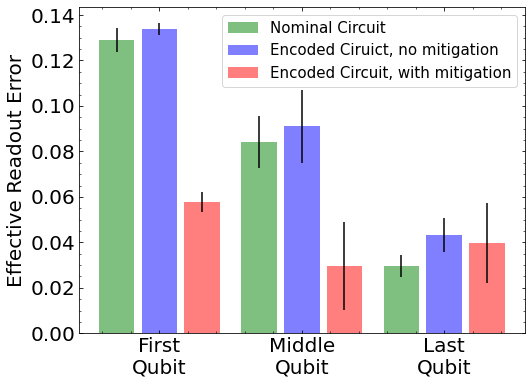

In [10]:
fig = plt.figure(figsize=(8, 6)) 
gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
ax0.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.bar(1,np.mean(ovals[15,1]),width=0.25,yerr=np.std(ovals[15,1]),color="green",label="Nominal Circuit",alpha=0.5)
plt.bar(1.3,np.mean(ovals[15,0]),width=0.25,yerr=np.std(ovals[15,0]),color="blue",label="Encoded Ciruict, no mitigation",alpha=0.5)
plt.bar(1.6,np.mean(ovals[15,2]),width=0.25,yerr=np.std(ovals[15,2]),color="red",label="Encoded Circuit, with mitigation",alpha=0.5)

plt.bar(1+1.3,np.mean(ovals[17,0]),width=0.25,yerr=np.std(ovals[17,0]),color="blue",alpha=0.5)
plt.bar(1+1,np.mean(ovals[17,1]),width=0.25,yerr=np.std(ovals[17,1]),color="green",alpha=0.5)
plt.bar(1+1.6,np.mean(ovals[17,2]),width=0.25,yerr=np.std(ovals[17,2]),color="red",alpha=0.5)

plt.bar(2+1.3,np.mean(ovals[19,0]),width=0.25,yerr=np.std(ovals[19,0]),color="blue",alpha=0.5)
plt.bar(2+1,np.mean(ovals[19,1]),width=0.25,yerr=np.std(ovals[19,1]),color="green",alpha=0.5)
plt.bar(2+1.6,np.mean(ovals[19,2]),width=0.25,yerr=np.std(ovals[19,2]),color="red",alpha=0.5)

plt.xticks([1.3,2.3,3.3],["First\nQubit","Middle\nQubit","Last\nQubit"],fontsize=20)
plt.ylabel("Effective Readout Error",fontsize=20)
plt.legend(fontsize=15)
#fig.savefig('EffectiveReadoutError.pdf',bbox_inches='tight')

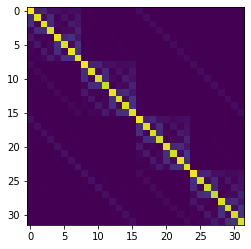

In [11]:
plt.imshow(myresponse)

In [12]:
diagonal = [myresponse[i,i] for i in range(32)]
diagonal2 = [myresponse2[i,i] for i in range(32)]

(0.6, 0.85)

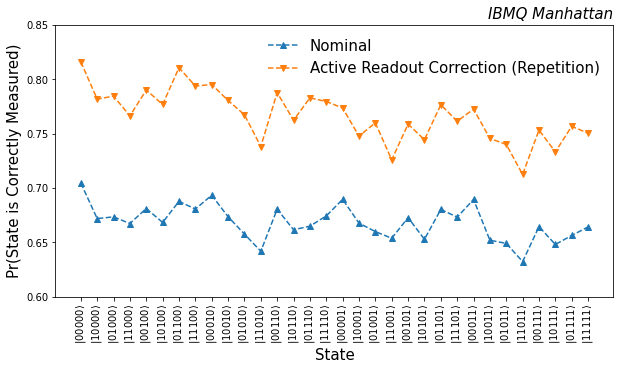

In [13]:
xvals = []
xlabs = []
for i in range(32):
  xvals+=[i]
  xlabs+=[r'$|'+mybin(i,5)+r'\rangle$']
  pass

f = plt.figure(figsize=(10, 5))
plt.plot(range(32),diagonal,label="Nominal",marker='^',ls='--')
plt.plot(range(32),diagonal2,label="Active Readout Correction (Repetition)",marker='v',ls='--')
_,_=plt.xticks(xvals,xlabs,rotation='vertical',fontsize=10)
plt.xlabel("State",fontsize=15)
plt.ylabel("Pr(State is Correctly Measured)",fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.title("IBMQ Manhattan",fontstyle="italic",loc="right",fontsize=15)
plt.ylim([0.6,0.85])
#f.savefig('FullState.pdf',bbox_inches='tight')